In [2]:
import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats, optimize

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import importlib
import nwp_aws_plotter as nwp_plotter

if os.path.exists('latex_default.mplstyle'):
    plt.style.use('latex_default.mplstyle')

In [50]:
data_folder = "./../profile-forecasts/data"

arome_stacked_path = os.path.join(data_folder, "arome-inca", "nwp_stacked.nc")
ecmwf_stacked_path = os.path.join(data_folder, "ecmwf-inca", "nwp_stacked.nc")
# nwp_data_path_date = "./arome-inca/20230123/arome_inca.t00z.nc"

"""Define location (eventually coordinates of an AWS)"""
aws_list = ["AXLIZ","GJAM","ISEE","KAUN","AKLE","SSON","SDAW","GGAL"] # "NGAN" keine Windstation
station_infos = []
for entry in aws_list:
    station_info = {'name':entry}
    station_infos.append(station_info)

# stations = getlist(["snowpack", "meteo", "stations"], domain)
# stations_to_download = ["ISEE1","ISEE2","AXLIZ1","AXLIZ2"]
stations_to_download = []
for station_info in station_infos:
    stations_to_download.append(station_info['name']+"1")
    stations_to_download.append(station_info['name']+"2")

print("[I]   Stations to download: ", stations_to_download)

sdate    = "2022-11-01"
ndays    = 160
sdate_dt = datetime.strptime(sdate, "%Y-%m-%d")
edate_dt = sdate_dt + timedelta(days=ndays)
edate    = edate_dt.strftime("%Y-%m-%d")
#edate    = "2023-01-25"

ds_aro = xr.open_dataset(arome_stacked_path)
ds_ifs = xr.open_dataset(ecmwf_stacked_path)

"""Formatting"""
fields_nwp  = ['TMP_2maboveground', 'RH_2maboveground', 'WIND_10maboveground', 'WDIR_10maboveground', 
                    'GUST_surface', 'NSWRS_surface', 'DLWRF_surface', 'APCP_surface']
fields_snp  = ['TA', 'RH', 'VW', 'DW', 'VW_MAX', 'ISWR', 'ILWR', 'PSUM']
fields_dict = dict(zip(fields_nwp, fields_snp))
ds_aro = ds_aro.rename(fields_dict)
ds_ifs = ds_ifs.rename(fields_dict)

ds_ifs['TA'] = ds_ifs['TA'] - 273.15
# nwp_data_path_date = os.path.join(data_folder, "arome-inca", "20221231", "ecmwf_inca.t00z.nc")
# nwp_data_path_date_2 = os.path.join(data_folder, "arome-inca", "20221231", "arome_inca.t00z.nc")
# ds_aro = xr.open_dataset(nwp_data_path_date)
# ds_aro["TMP_2maboveground"] = ds_aro["TMP_2maboveground"] - 273.15
# ds_aro.to_netcdf(nwp_data_path_date_2)
nwp_models = [ds_ifs, ds_aro]
ds_ifs

[I]   Stations to download:  ['AXLIZ1', 'AXLIZ2', 'GJAM1', 'GJAM2', 'ISEE1', 'ISEE2', 'KAUN1', 'KAUN2', 'AKLE1', 'AKLE2', 'SSON1', 'SSON2', 'SDAW1', 'SDAW2', 'GGAL1', 'GGAL2']


<xarray.Dataset>
Dimensions:                  (x: 227, y: 170, time: 3624)
Coordinates:
  * x                        (x) int32 148000 149000 150000 ... 373000 374000
  * y                        (y) int32 429000 428000 427000 ... 261000 260000
  * time                     (time) datetime64[ns] 2022-11-01 ... 2023-03-31T...
    lon                      (y, x) float64 ...
    lat                      (y, x) float64 ...
Data variables:
    TA                       (time, y, x) float32 10.37 10.3 10.3 ... 8.18 7.31
    RH                       (time, y, x) float32 ...
    PSUM                     (time, y, x) float32 ...
    VW                       (time, y, x) float32 ...
    DW                       (time, y, x) float32 ...
    VW_MAX                   (time, y, x) float32 ...
    ISWR                     (time, y, x) float32 ...
    ILWR                     (time, y, x) float32 ...
    sunshine_perc            (time, y, x) float32 ...
    lambert_conformal_conic  (time) |S8 ...
    HGT_surface              (time, y, x) float32 ...
Attributes:
    comment:        Horizontal resolution: 1 km
    title:          Deterministic ECMWF Forecast downscaled inca grid Tyrol/S...
    CDI:            Climate Data Interface version 1.5.2 (http://code.zmaw.de...
    Conventions:    CF-1.6
    contact:        Roland Koch (roland.koch@zamg.ac.at)
    creation_date:  2022-11-01 08:00:04
    institution:    ZAMG - Zentralanstalt fuer Meteorologie und Geodynamik, V...

In [51]:
"""Download AWS data"""
importlib.reload(nwp_plotter)
aws_data_dir = os.path.join(data_folder, "aws")
#download_script_path = "/home/data/query/wiski/wiski_rest.py" # awsome-server
download_script_path = "./../wiski/wiski_rest.py" # cmb
nwp_plotter._download_sp_stations(stations_to_download, sdate, edate, aws_data_dir, download_script_path)

[i] Downloading from https://lwdtirol@wiski-daten.tirol.gv.at/timeseries?modus=SMET&station=AXLIZ1&parameter=*&interval=2022-11-01/2023-04-10&missingValue=-999
[i] Downloading from https://lwdtirol@wiski-daten.tirol.gv.at/timeseries?modus=SMET&station=AXLIZ2&parameter=*&interval=2022-11-01/2023-04-10&missingValue=-999
[i] Downloading from https://lwdtirol@wiski-daten.tirol.gv.at/timeseries?modus=SMET&station=GJAM1&parameter=*&interval=2022-11-01/2023-04-10&missingValue=-999
[i] Downloading from https://lwdtirol@wiski-daten.tirol.gv.at/timeseries?modus=SMET&station=GJAM2&parameter=*&interval=2022-11-01/2023-04-10&missingValue=-999
[i] Downloading from https://lwdtirol@wiski-daten.tirol.gv.at/timeseries?modus=SMET&station=ISEE1&parameter=*&interval=2022-11-01/2023-04-10&missingValue=-999
[i] Downloading from https://lwdtirol@wiski-daten.tirol.gv.at/timeseries?modus=SMET&station=ISEE2&parameter=*&interval=2022-11-01/2023-04-10&missingValue=-999
[i] Downloading from https://lwdtirol@wiski-

In [52]:
"""Load and process AWS data"""
dfs_aws  = []
data_crs = ccrs.LambertConformal(central_longitude=13.33333333333, central_latitude=47.5, standard_parallels=[46,49], false_easting=400000, false_northing=400000)
for station_info in station_infos:
    if station_info['name'] == 'AXLIZ' or station_info['name'] == 'PROS':
        aws_data_path1 = os.path.join(aws_data_dir,station_info["name"] + "2.smet") # AXLIZ should be reversed
        aws_data_path2 = os.path.join(aws_data_dir,station_info["name"] + "1.smet") # AXLIZ should be reversed
    else:
        aws_data_path1 = os.path.join(aws_data_dir,station_info["name"] + "1.smet")
        aws_data_path2 = os.path.join(aws_data_dir,station_info["name"] + "2.smet")

    """Snow station (2)"""
    df_aws_meta = pd.read_csv(aws_data_path2, skiprows=2, sep='=',  nrows = 11, names=['parameter','value'])
    params = df_aws_meta['value'][8].split()
    df_aws = pd.read_csv(aws_data_path2, skiprows=14, sep=' ', names=params)
    df_aws["RH"] = df_aws["RH"]*100
    df_aws["TA"] = df_aws["TA"]-273.15
    df_aws["TSS"] = df_aws["TSS"]-273.15

    station_info['latitude']  = float(df_aws_meta['value'][2])
    station_info['longitude'] = float(df_aws_meta['value'][3])
    station_info['altitude']  = int(float(df_aws_meta['value'][4]))

    """Wind station (1)"""
    if 'VW' not in df_aws.columns:
        df_aws_meta_wind = pd.read_csv(aws_data_path1, skiprows=2, sep='=', nrows = 11, names=['parameter','value'])
        params_wind = df_aws_meta_wind['value'][8].split()
        if station_info['name'] == 'AXLIZ' or station_info['name'] == 'SSON':
            params_wind[-3] = "DW_MAX"
        df_aws_wind = pd.read_csv(aws_data_path1, skiprows=14, sep=' ', names=params_wind)

        df_aws["VW"] = df_aws_wind["VW"]
        df_aws["DW"] = df_aws_wind["DW"]
    
    """Rename and format"""
    df_aws.rename(columns={"timestamp":"time"},inplace=True)

    format = '%Y-%m-%dT%H:%M:%SZ' # 2023-01-10T23:00:00Z
    df_aws["time"] = pd.to_datetime(df_aws["time"], format=format)
    # df_aws.set_index(df_aws["time"] ,inplace=True)
    # df_aws = df_aws.resample('H', on='time').mean()
    dfs_aws.append(df_aws)

    """Meta data like coordinates"""
    station_info['easting'], station_info['northing'] = data_crs.transform_point(station_info['longitude'],station_info['latitude'], src_crs=ccrs.PlateCarree())
    print('Station: {} Lon: {}, Lat: {}, x (Easting): {}, y (Northing): {}'.format(station_info['name'], station_info['longitude'],station_info['latitude'],station_info['easting'],station_info['northing']))

Station: AXLIZ Lon: 11.2880109778398, Lat: 47.1801049847685, x (Easting): 245032.8288566957, y (Northing): 366486.482511189
Station: GJAM Lon: 10.177635, Lat: 46.885912, x (Easting): 159614.02659563432, y (Northing): 336632.9338879054
Station: ISEE Lon: 11.3779335010812, Lat: 47.3063819943737, x (Easting): 252197.61652189758, y (Northing): 380340.919721706
Station: KAUN Lon: 10.76282, Lat: 47.071488, x (Easting): 204854.65156368338, y (Northing): 355603.4790207049
Station: AKLE Lon: 12.01605, Lat: 47.351489, x (Easting): 300510.0326629777, y (Northing): 384337.62407180574
Station: SSON Lon: 11.0103777777778, Lat: 46.87435, x (Easting): 222987.68361620972, y (Northing): 333112.1160974951
Station: SDAW Lon: 10.462350017993, Lat: 47.1503195001747, x (Easting): 182377.37782275697, y (Northing): 365157.33596248797
Station: GGAL Lon: 11.335489, Lat: 47.052267, x (Easting): 248264.02330146608, y (Northing): 352189.9675724247


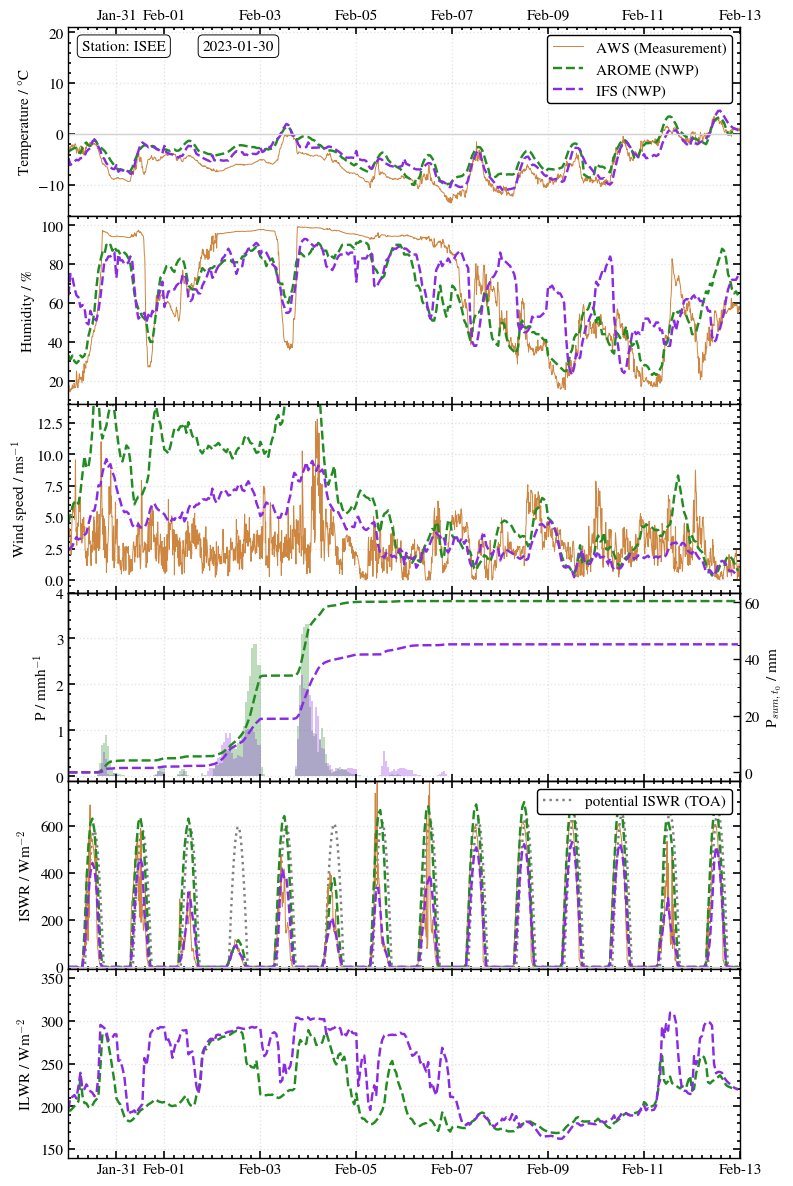

In [67]:
"""Timeseries plot similar to visualization of weather stations"""
importlib.reload(nwp_plotter)
## sdate should be from above for P_CUMSUM (cumulative precip)
sdate_series  = "2023-01-30"
# edate       = "2023-02-05"
days          = 14
sdate_dt      = datetime.strptime(sdate_series, "%Y-%m-%d")
edate_dt      = sdate_dt + timedelta(days=days)
edate_series  = datetime.strftime(edate_dt, "%Y-%m-%d")

istation      = 2
station_info  = station_infos[istation]
df_aws        = dfs_aws[istation]
nwp_plotter.plot_timeseries(ds_aro, ds_ifs, station_info, df_aws=df_aws, sdate=sdate_series, edate=edate_series)

Locator attempting to generate 1412 ticks ([-1336.0, ..., 75.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1412 ticks ([-1336.0, ..., 75.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1412 ticks ([-1336.0, ..., 75.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1412 ticks ([-1336.0, ..., 75.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1412 ticks ([-1336.0, ..., 75.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1412 ticks ([-1336.0, ..., 75.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1412 ticks ([-1336.0, ..., 75.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1412 ticks ([-1336.0, ..., 75.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1412 ticks ([-1336.0, ..., 75.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1412 ticks ([-1336.0, ..

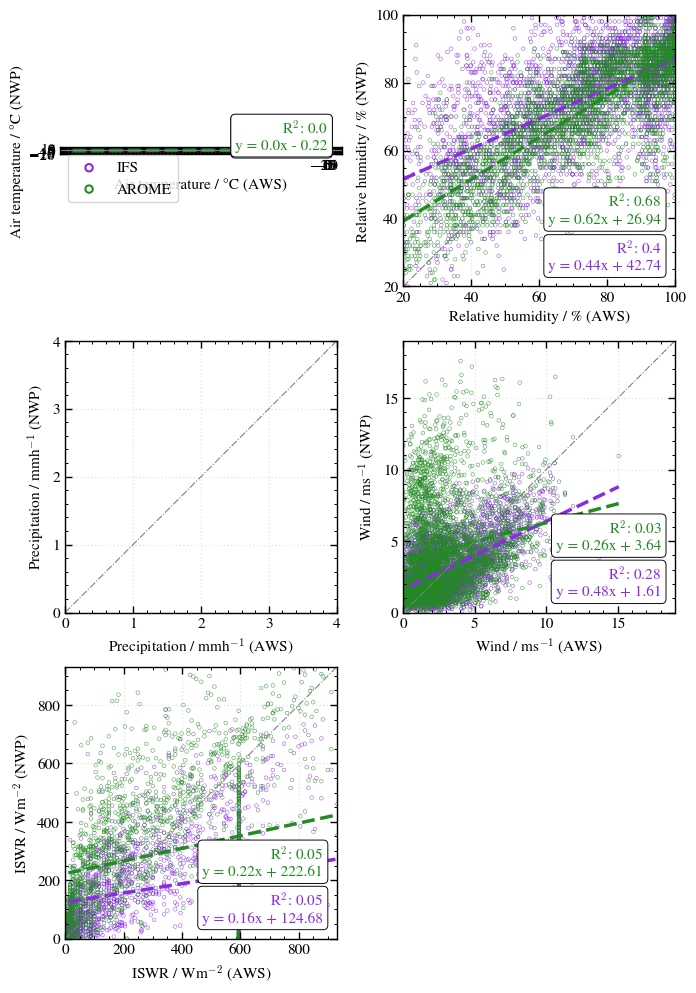

In [66]:
"""Scatter plots"""
importlib.reload(nwp_plotter)

######
# sdate    = "2022-11-01"
# ndays    = 150
# sdate_dt = datetime.strptime(sdate, "%Y-%m-%d")
# edate_dt = sdate_dt + timedelta(days=ndays)
# edate    = edate_dt.strftime("%Y-%m-%d")
######

istation     = 2
station_info = station_infos[istation]
df_aws       = dfs_aws[istation]
nwp_plotter.scatter_plots_nwp_aws(nwp_models, station_info, df_aws, sdate=sdate, edate=edate)

/var/folders/5n/r616r2rx3710m3kyf90_xwdr0000gn/T/ipykernel_41455/4162953246.py:65: UserWarning: The label '_child14' of <matplotlib.lines.Line2D object at 0x2af191eb0> starts with '_'. It is thus excluded from the legend.
  dia._ax.legend(dia.samplePoints, spl, numpoints=1, ncols=3, loc=[0.02,0.02], fontsize=9, framealpha=0.85)
/var/folders/5n/r616r2rx3710m3kyf90_xwdr0000gn/T/ipykernel_41455/4162953246.py:65: UserWarning: The label '_child16' of <matplotlib.lines.Line2D object at 0x2af19b430> starts with '_'. It is thus excluded from the legend.
  dia._ax.legend(dia.samplePoints, spl, numpoints=1, ncols=3, loc=[0.02,0.02], fontsize=9, framealpha=0.85)
/var/folders/5n/r616r2rx3710m3kyf90_xwdr0000gn/T/ipykernel_41455/4162953246.py:65: UserWarning: The label '_child18' of <matplotlib.lines.Line2D object at 0x2af19b970> starts with '_'. It is thus excluded from the legend.
  dia._ax.legend(dia.samplePoints, spl, numpoints=1, ncols=3, loc=[0.02,0.02], fontsize=9, framealpha=0.85)
/var/folde

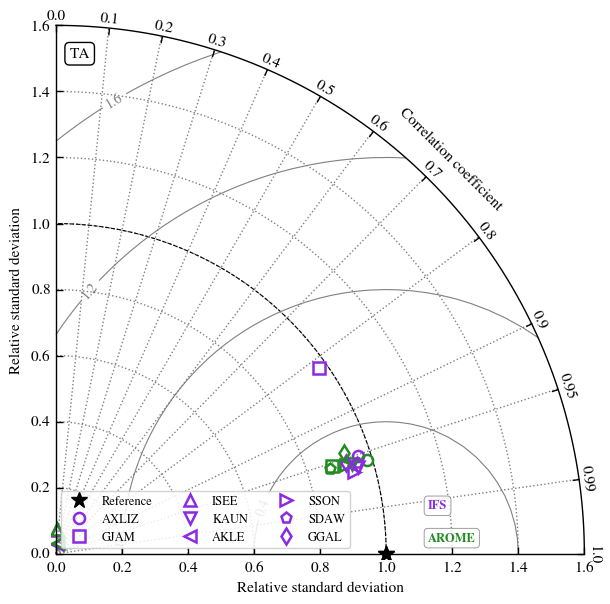

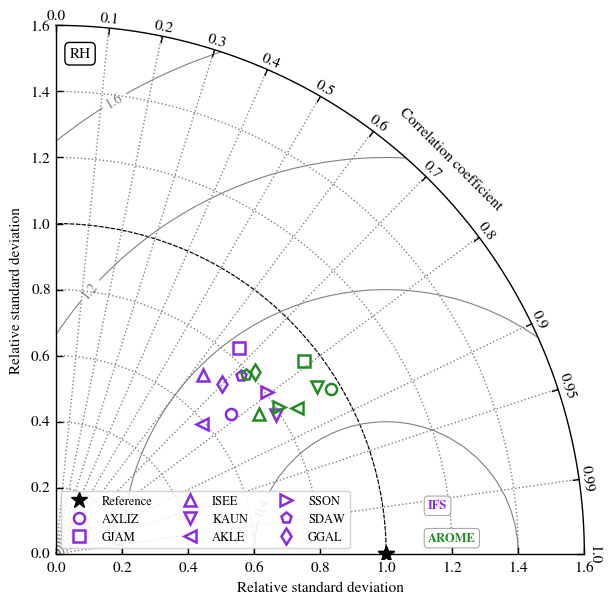

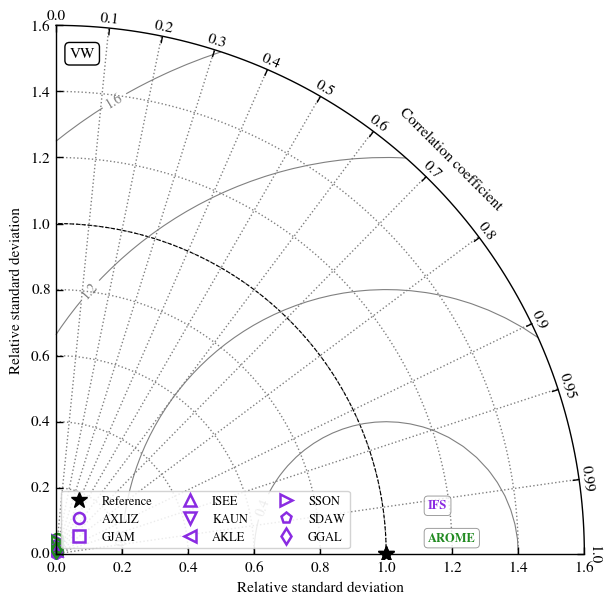

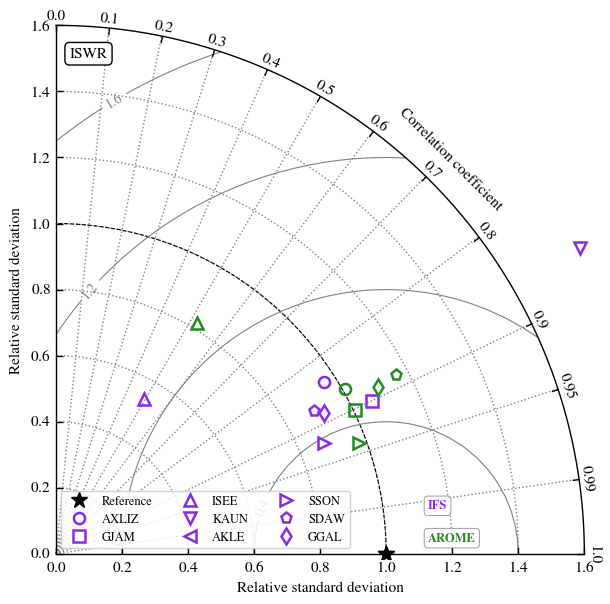

In [68]:
"""Taylor Diagram (for multiple stations)
- We need Pearson correlation coefficient, RMSE, Standard deviation for each variable and each model compared to AWS

"""

def calc_taylor_stats(var_aws,var_nwp):
  idx = np.isfinite(var_aws) & np.isfinite(var_nwp)
  slope_m, y_intercept, r_value, p_value, std_err = stats.linregress(var_aws[idx], var_nwp[idx])
  std_aws = np.std(var_aws[idx])
  std_nwp = np.std(var_nwp[idx])
  rel_std = std_nwp/std_aws

  return r_value, rel_std

def generate_taylor_diagram(nwp_models,dfs_aws, station_infos, sdate=sdate, edate=edate, var="TA"):
  """Each weather station gets an icon, each model a color"""
  nwp_cols   = ['blueviolet', 'forestgreen']  
  nwp_labels = ['IFS', 'AROME']
  nwp_colors = dict(zip(nwp_labels, nwp_cols))

  edate_dt      = datetime.strptime(edate, "%Y-%m-%d")
  edate_dt_sel  = edate_dt - timedelta(days=1)
  edate_sel     = edate_dt_sel.strftime("%Y-%m-%d")
  
  stats = {} # keys are station names
  for j, df_aws in enumerate(dfs_aws):
    station_info = station_infos[j]
    station_name = station_info['name']
    stats[station_name] = {"r_value":[], "rel_std":[]}
    for i, ds_nwp in enumerate(nwp_models):
      """Select NWP data"""
      ds_nwp0 = ds_nwp.sel(x=station_info['easting'],y=station_info['northing'],method='nearest')
      ds_nwp0 = ds_nwp0.sel(time=slice(sdate,edate_sel))
    
      """Filter AWS data with NWP timestamps data (hourly data)"""
      # if "PSUM" in df_aws.columns:
      #     wbar = df_aws.time[10]-df_aws.time[9]
      #     tres = wbar.seconds // 60
      #     df_aws['PSUM_scaled'] = df_aws['PSUM'].rolling(window=int(60/tres)).sum()
        
      df_aws0 = df_aws[df_aws['time'].isin(ds_nwp0.time.values)]
        
      """Scatter plots"""
      r_value, rel_std = calc_taylor_stats(df_aws0[var].values,ds_nwp0[var].values)
      stats[station_name]["r_value"].append(r_value)
      stats[station_name]["rel_std"].append(rel_std)

  fig = plt.figure(figsize=(7,7))
  std_obs = 1
  dia = nwp_plotter.TaylorDiagram(std_obs, fig=fig, rect=111, label='Reference')
  plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)

  aws_marker = ["o","s","^","v","<",">","p","d","P","X","*"]
  mew = 1.8
  ms  = 100
  ms  = 8
  for j, station_info in enumerate(station_infos):
    station_name = station_info['name']
    dia.add_sample(stats[station_name]["rel_std"][0], stats[station_name]["r_value"][0], label=station_name, linestyle='', marker=aws_marker[j], ms=ms, mec=nwp_colors[nwp_labels[0]], mfc = 'none', mew=mew)
    # dia.add_sample_scatter(stats[station_name]["rel_std"][0], stats[station_name]["r_value"][0], label=station_name, marker=aws_marker[j], s=ms, edgecolors=nwp_colors[nwp_labels[0]], facecolors=None, linewidths=mew)
    for i in range(1,len(nwp_models)):
      dia.add_sample(stats[station_name]["rel_std"][i], stats[station_name]["r_value"][i], linestyle='', marker=aws_marker[j], ms=ms, mec=nwp_colors[nwp_labels[i]], mfc = 'none', mew=mew)

  spl = [p.get_label() for p in dia.samplePoints]
  dia._ax.legend(dia.samplePoints, spl, numpoints=1, ncols=3, loc=[0.02,0.02], fontsize=9, framealpha=0.85)
  
  # Add text field with models
  for i, key in enumerate(nwp_colors):
    dia._ax.text(0.7, 0.11-0.06*i, key, fontweight='bold', fontsize=9, transform=dia._ax.transAxes, color=nwp_colors[key], verticalalignment='top', bbox={"boxstyle" : "round", "lw":0.67, "facecolor":"white", "edgecolor":"gray", "alpha":0.8})
  dia._ax.text(0.035, 0.95, var, fontsize=11, transform=dia._ax.transAxes, verticalalignment='top', bbox={"boxstyle" : "round", "lw":1, "facecolor":"white", "edgecolor":"black", "alpha":1})


  folder     = 'output'
  fig_title  = "taylor_diagram_" + sdate + "_" + var + ".png"
  fig.savefig(os.path.join(folder,fig_title), facecolor='w', edgecolor='w',
              format='png', dpi=150)
  
vars = ["TA","RH","VW","ISWR"] # PSUM
# vars = ["RH"]
for var in vars:
  generate_taylor_diagram(nwp_models, dfs_aws, station_infos, sdate=sdate, edate=edate, var=var)

In [ ]:
# if "AXLIZ" in aws_list:
#     station_info = {'name'        : 'AXLIZ',
#                     'latitude'    : 47.1801049847685,
#                     'longitude'   : 11.2880109778398,
#                     'easting'     : 245032.82885, # 222388.14,
#                     'northing'    : 366486.4825, # 227240.4,
#                     'altitude'    : 2103}
#     station_infos.append(station_info)

# if "GJAM" in aws_list:
#     station_info = {'name'        : 'GJAM',
#                     'latitude'    : 46.885912,
#                     'longitude'   : 10.177635,
#                     'altitude'    : 2172}
#     station_infos.append(station_info)

# if "ISEE" in aws_list:
#     station_info = {'name'        : 'ISEE',
#                     'latitude'    : 47.3063819943737,
#                     'longitude'   : 11.3779335010812,
#                     'altitude'    : 1921}
#     station_infos.append(station_info)

# if "KAUN" in aws_list:
#     station_info = {'name'        : 'KAUN',
#                     'latitude'    : 47.071488,
#                     'longitude'   : 10.76282,
#                     'altitude'    : 2038}
#     station_infos.append(station_info)

In [ ]:
# def scatter_plot_lead_time()
"Single variable scatter plot to visualize NWP - AWS observation with color code refering to lead time"